# Regridding WRF-BCC

In [1]:
import pandas as pd
import xarray as xr
import xoak
import numpy as np
import matplotlib.pyplot as plt
import regionmask
import cartopy
import cartopy.crs as ccrs
import glob
%matplotlib inline

### Loading Data

In [2]:
#load dataframes
refc_df = pd.read_csv('/home/scratch/jcorner1/syn_sev/dataframes/HIST_REFC_1991_threshold_dataframe.csv')
uh_df = pd.read_csv('/home/scratch/jcorner1/syn_sev/dataframes/HIST_UH_1991_threshold_dataframe.csv')

#concat the dataframes
df = pd.concat([uh_df, refc_df])
df = df.drop_duplicates(subset=['x','y','Time'])
df

,Unnamed: 0,x,y,Time,UH,DBZ,UVV
0,0,753,483,1990-10-31T01:00:00.000000000,35.804810,13.807288,12.857470
1,1,754,483,1990-10-31T01:00:00.000000000,35.848896,37.720950,12.006787
2,2,749,411,1990-10-31T04:00:00.000000000,42.497177,51.801662,17.208110
3,3,750,411,1990-10-31T04:00:00.000000000,41.811430,40.762430,13.348378
4,4,750,412,1990-10-31T04:00:00.000000000,35.797220,40.055344,12.823191
...,...,...,...,...,...,...,...
3091321,3091321,531,551,1991-09-30T00:00:00.000000000,0.534079,40.408497,5.414321
3091322,3091322,531,552,1991-09-30T00:00:00.000000000,0.113595,41.695515,7.604637
3091323,3091323,570,642,1991-09-30T00:00:00.000000000,6.573773,43.500870,8.289806
3091324,3091324,571,642,1991-09-30T00:00:00.000000000,8.560321,40.695244,7.508680


In [3]:
#open dummy xarray dataset
ds = xr.open_dataset('/home/scratch/WRF_BCC/severe_weather/UP_HELI_MAX/historical/1990-1991/UP_HELI_MAX_historical-1990-1991_1990-10-01.nc')
ds = ds.sel(Time ='1990-10-01T00:00:00.000000000')
ds_copy = ds.copy()

### Data Conversion

In [4]:
def Data_Conv(ds):
    
    '''
    A defintion  
    
    Parameters
    ----------
    ds: xarray dataset
    
    Returns
    -------
    ds: returns a coarsened data with lat/long
    
    '''
    geog = xr.open_dataset("/home/scratch/WRF_BCC/geography/geo_em.d01.nc")
    geog = geog[['CLAT', 'CLONG']].coarsen(south_north=20, west_east=20, boundary='trim').mean()
    
    ds = ds.coarsen(south_north=20, west_east=20, boundary='trim').sum()
    ds = xr.merge([ds, geog.squeeze()])
    ds = ds.rename({"CLONG": 'lon', 'CLAT': 'lat'})

    ds = ds.assign_coords({'x': ds.west_east, 'y': ds.south_north})
    ds = ds.assign_coords({'lon': ds.lon, 'lat': ds.lat})
    ds.xoak.set_index(['lat', 'lon'], 'sklearn_geo_balltree')
    
    return ds

In [5]:
#threshold the files
df_new = df[((df['DBZ'] >= 40.0) & (df['UH'] >= 35.0))]
print(f'amount of rows removed from dataframe: {len(df) - len(df_new)}')

amount of rows removed from dataframe: 3150460


In [6]:
zeros = np.zeros((899,1399))

for rid, row in df_new.iterrows():
    zeros[row['y'], row['x']] = zeros[row['y'], row['x']] + 1
    
zeros[zeros == 0.0] = np.nan

ds = ds_copy.assign(UP_HELI_MAX = (('south_north', 'west_east'), zeros))

ds_cor = Data_Conv(ds)

### Plotting Data

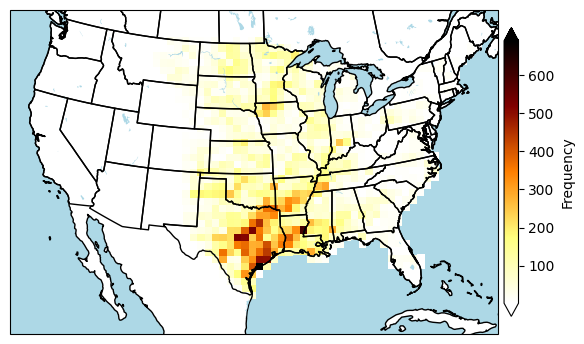

In [7]:
#Create a subplot
plt.figure(figsize=(7.5,7.5))
ax = plt.subplot(1,1,1, projection=ccrs.LambertConformal(central_longitude=-98, central_latitude=35))

#create nans for the 0 data spots
data = ds_cor.UP_HELI_MAX.values
data[data==0] = np.nan
c = ax.pcolormesh(ds_cor.lon.values, ds_cor.lat.values, data, cmap='afmhot_r', transform=cartopy.crs.PlateCarree(), vmax=int(np.nanmax(data)))

#add features to help reference map
ax.add_feature(cartopy.feature.STATES, zorder=2)
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.LAND, facecolor='white')
ax.add_feature(cartopy.feature.OCEAN, facecolor='lightblue')
ax.add_feature(cartopy.feature.LAKES, facecolor='lightblue')
ax.set_extent([-120, -74, 20, 50])

#create colorbar
cbar = plt.colorbar(c, shrink=0.5, pad=0.01, extend='both', ticks=list(range(0, 701, 100)), ax=ax)
cbar.ax.tick_params(labelsize=10)
cbar.set_label(label='Frequency', size=10)